# Drought Network - Refinement

a. stein

8.4.2022

This picks up where `explore/drought_event_network.ipynb` left off, presenting a cleaner demonstration of the test case and cleaning up plotting functionality.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.drought_network as dnet


import networkx as nx

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


## Test Cases - Cellular Automata

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

### 3x3 bounded grid (hard-coded)

In [3]:
ca_matrix_3x3 = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
])
ca_matrix_3x3

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

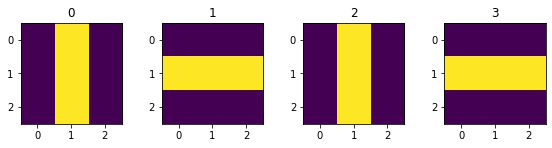

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(8,2))

ca_series_3x3 = []
plot_matrix = ca_matrix_3x3

for i, ax in enumerate(axs.ravel()):
    ca_series_3x3.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_3x3 = np.array(ca_series_3x3)

plt.tight_layout()

In [5]:
ca_net_3x3 = dnet.DroughtNetwork(ca_series_3x3)

  0%|          | 0/4 [00:00<?, ?it/s]

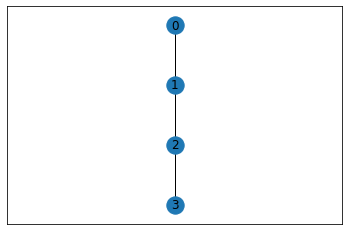

In [6]:
topog, pos = ca_net_3x3.get_nx_network()
nx.draw_networkx(topog, pos)

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

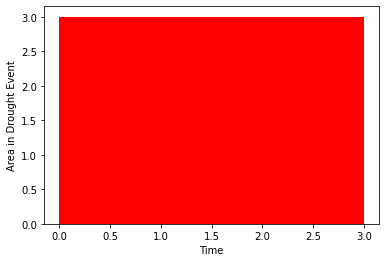

In [7]:
ca_net_3x3.stacked_events_plot()

### 5x5 bounded grid (hard-coded)

In [8]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
ca_matrix_5x5 = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

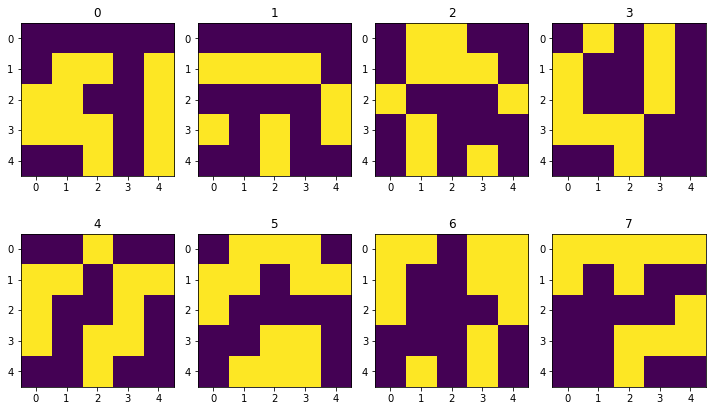

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

ca_series_5x5 = []
plot_matrix = ca_matrix_5x5

for i, ax in enumerate(axs.ravel()):
    ca_series_5x5.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_5x5 = np.array(ca_series_5x5)

plt.tight_layout()

In [10]:
ca_net_5x5 = dnet.DroughtNetwork(ca_series_5x5)

  0%|          | 0/8 [00:00<?, ?it/s]

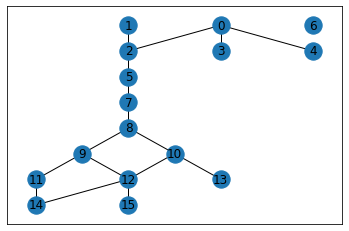

In [19]:
topog, pos = ca_net_5x5.get_nx_network()
nx.draw_networkx(topog, pos)

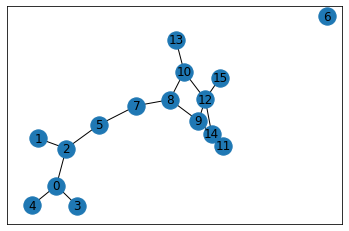

In [20]:
nx.draw_networkx(topog)

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

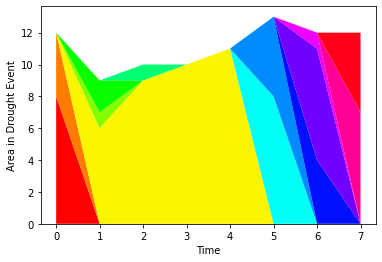

In [12]:
ca_net_5x5.stacked_events_plot()

### 15x15 bounded grid (random)

In [13]:
ca_matrix_15x15 = np.zeros((15,15))

for i in np.arange(ca_matrix_15x15.shape[0]):
    for j in np.arange(ca_matrix_15x15.shape[1]):
        ca_matrix_15x15[i][j] = np.random.randint(2)

ca_matrix_15x15

array([[1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1.],
       [1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
       [1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
       [1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1.],
       [1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 0., 1.

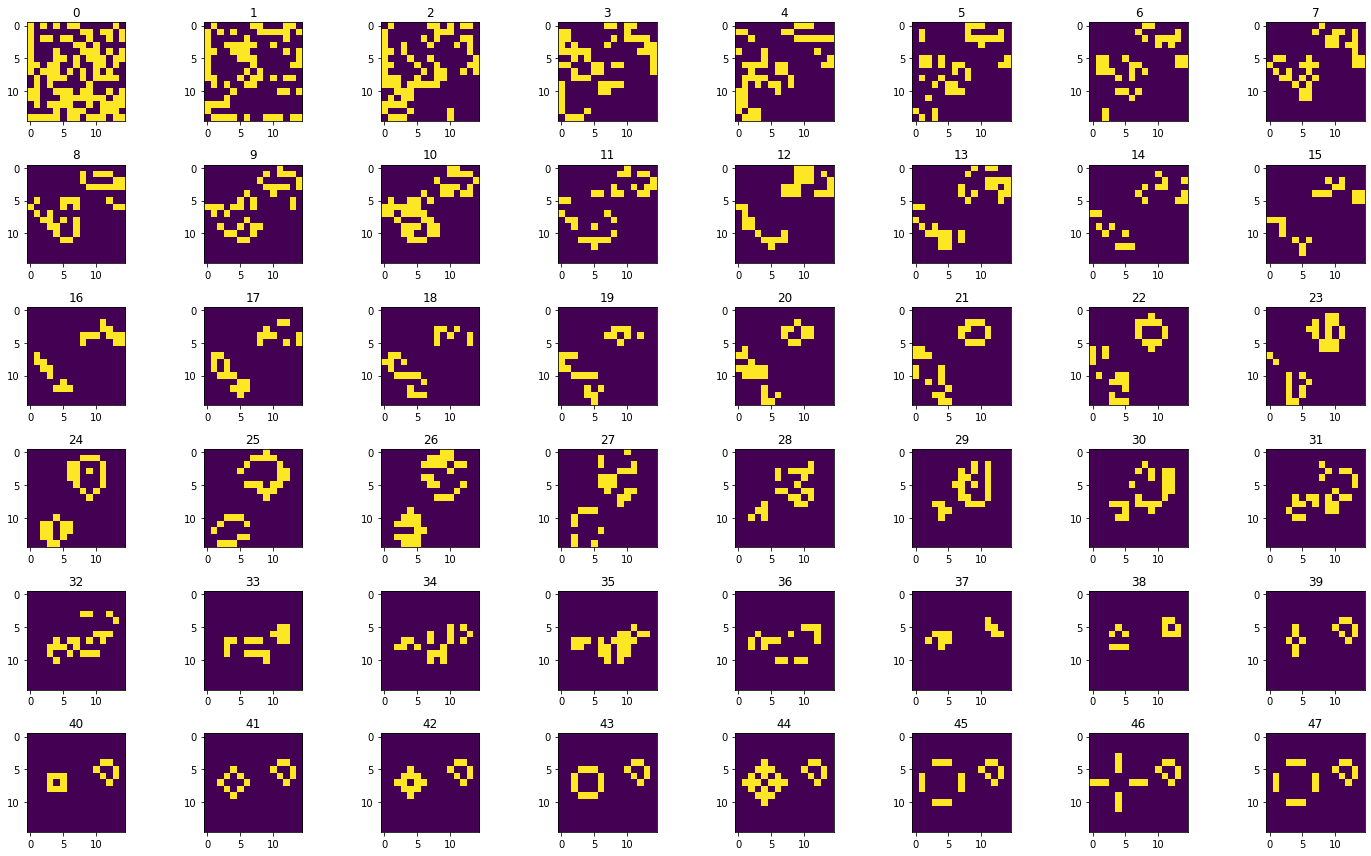

In [14]:
fig, axs = plt.subplots(6, 8, figsize=(20,12))

ca_series_15x15 = []
plot_matrix = ca_matrix_15x15

for i, ax in enumerate(axs.ravel()):
    ca_series_15x15.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

ca_series_15x15 = np.array(ca_series_15x15)

plt.tight_layout()

In [15]:
ca_net_15x15 = dnet.DroughtNetwork(ca_series_15x15)

  0%|          | 0/48 [00:00<?, ?it/s]

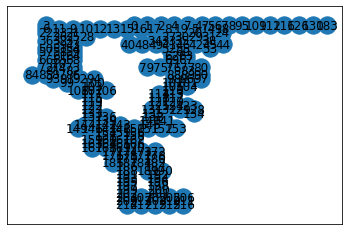

In [16]:
topog, pos = ca_net_15x15.get_nx_network()
nx.draw_networkx(topog, pos)

<AxesSubplot:xlabel='Time', ylabel='Area in Drought Event'>

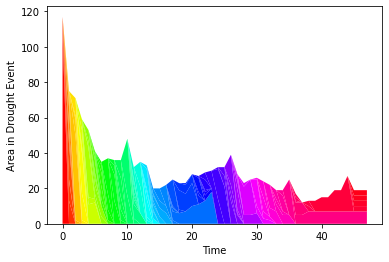

In [17]:
ca_net_15x15.stacked_events_plot()

## Application - USDM

## Application - SPI